# Detection and segmentation of cell nuclei using Deep Learning on the Cloud
## Arturo Bayo - Data Science Bowl 2018

La arquitectura utilizada para resolver el reto de identificación de núcleos celulares en imágenes de microescopio es la llamada [U-Net](https://arxiv.org/abs/1505.04597), muy común para problemas de segmentación de imágenes biomédicas como las de este reto. El nombre de U-Net viene por la forma con la que se representa a la red neuronal, como se aprecia en la siguiente imagen:

<img src="https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png">

En concreto, este projecto está basado en el siguiente template: https://www.kaggle.com/keegil/keras-u-net-starter-lb-0-277?scriptVersionId=2164855 y adaptado para ejecutar de forma completamente gestionada sobre Amazon SageMaker.

¡Comencemos!

In [145]:
import os
import sagemaker
from sagemaker import get_execution_role

sagemaker_session = sagemaker.Session()

role = get_execution_role()

# Obtener los datos
Contamos con las imágenes de entrenamiento y test proporcionadas por el challenge. Subiremos estos datos a S3 para alimentar el modelo en SageMaker.
- "input/demo_train" contiene un set reducido de datos para probar de forma rápida o desarrollar el modelo (entrenar con este set lleva menos de 3 minutos con una instancia ml.c4.xlarge)
- "input/stage1_train" contiene todo el set de entrenamiento completo (entrenar con este set lleva aproximadamente 35 minutos con una instancia ml.c4.xlarge)
- "input/stage1_test" contiene el set de test de data science bowl 2018

In [146]:
inputs = sagemaker_session.upload_data(path='input/demo_train', key_prefix='input/demo_train')

# Instanciar la imagen del modelo
SageMaker puede importar modelos desarrollados sobre Tensorflow, incluso si contienen módulos y librerías propietarias. Simplemente se necesita crear una imagen Docker que la interfaz definida en la siguiente documentación:
https://docs.aws.amazon.com/sagemaker/latest/dg/your-algorithms-training-algo.html

De forma resumida, SageMaker ejecutará los comandos "train" y "serve" para indicar al modelo que ejecute el código de entrenamiento o de inferencias, respectivamente. 

- Bajo "train" se encuentra el código que obtiene el conjunto de datos de entrenamiento, preprocesa los datos y entrena el modelo (típico model.fit()).

- Bajo "serve" se encuentra un servicio web sencillo con 2 endpoints: 
    1. "ping", que indica a SageMaker que el contenedor sigue activo.
    2. "invocations", que recibe el conjunto de datos sobre el que queremos realizar la predicción y devuelve el resultado inferido.


A modo de ejemplo, el siguiente proyecto es una buena plantilla para comenzar a adaptar el código de un modelo a una imagen Docker:
https://github.com/awslabs/amazon-sagemaker-examples/tree/master/advanced_functionality/scikit_bring_your_own


In [147]:
# Se obtienen las variables de la sesión activa: ID de cuenta de AWS y Región
account = sagemaker_session.boto_session.client('sts').get_caller_identity()['Account']
region = sagemaker_session.boto_session.region_name

# URL del Elastic Container Registry (ECR) que contiene la imágen Docker de nuestro modelo
image = '{}.dkr.ecr.{}.amazonaws.com/unet:latest'.format(account, region)

# El SDK de SageMaker crea un Estimador proporcionandole la imagen Docker y la infraestructura que soportará el entrenamiento (ej. 1 x c4.xlarge)
clf = sagemaker.estimator.Estimator(image,
                       role, 1, 'ml.c4.xlarge',
                       output_path="s3://{}/output".format(sagemaker_session.default_bucket()),
                       sagemaker_session=sagemaker_session,
                       hyperparameters=None)

# Entrenamiento del modelo
Una vez instanciado el estimador (clf), entrenamos el modelo con los datos de entrada que hemos subido previamente a S3.

- El método fit() de nuestro estimador creará un contenedor de nuestra imagen Docker y asociará los datos "inputs" a una ruta local donde el contenedor tiene acceso para obtener el conjunto de datos de entrenamiento
- Es posible configurar el comportamiento del entrenamiento (épocas, split...) a través de los hiperparametros establecidos en el paso anterior
- El entrenamiento finalizará cuando se haya llegado a un valor loss aceptable o SageMaker envíe la señal de timeout.

In [148]:
%%time
clf.fit(inputs)

INFO:sagemaker:Creating training-job with name: unet-2018-06-30-23-30-41-140


..........................
Using TensorFlow backend.
Starting the training.
Getting and resizing train images and masks ... 
#015  0%|          | 0/670 [00:00<?, ?it/s]#015  0%|          | 1/670 [00:00<03:48,  2.93it/s]#015  1%|          | 5/670 [00:00<01:04, 10.30it/s]#015  1%|          | 6/670 [00:00<01:07,  9.80it/s]#015  1%|1         | 7/670 [00:00<01:11,  9.32it/s]#015  1%|1         | 8/670 [00:00<01:11,  9.26it/s]#015  1%|1         | 9/670 [00:01<01:15,  8.73it/s]#015  2%|1         | 11/670 [00:01<01:13,  9.02it/s]#015  2%|1         | 13/670 [00:01<01:10,  9.32it/s]#015  2%|2         | 15/670 [00:01<01:12,  9.02it/s]#015  3%|2         | 17/670 [00:01<01:12,  9.05it/s]#015  3%|2         | 19/670 [00:02<01:11,  9.16it/s]#015  3%|3         | 22/670 [00:02<01:05,  9.93it/s]#015  4%|3         | 25/670 [00:02<01:14,  8.63it/s]#015  4%|4         | 27/670 [00:03<01:17,  8.29it/s]#015  4%|4         | 30/670 [00:03<01:12,  8.85it/s]#015  5%|4         | 32/670 [00:03<01:19,  8.07it/s]#015  

603/603 [==============================] - 88s 146ms/step - loss: 0.2902 - mean_iou: 0.4673 - val_loss: 0.1332 - val_mean_iou: 0.5492

Epoch 00001: val_loss improved from inf to 0.13319, saving model to /opt/ml/model/unet.h5
Epoch 2/30
592/603 [============================>.] - ETA: 1s - loss: 0.1407 - mean_iou: 0.6052


603/603 [==============================] - 86s 142ms/step - loss: 0.1397 - mean_iou: 0.6059 - val_loss: 0.1199 - val_mean_iou: 0.6465

Epoch 00002: val_loss improved from 0.13319 to 0.11987, saving model to /opt/ml/model/unet.h5
Epoch 3/30
603/603 [==============================] - 86s 142ms/step - loss: 0.1357 - mean_iou: 0.6657 - val_loss: 0.1391 - val_mean_iou: 0.6866

Epoch 00003: val_loss did not improve from 0.11987
Epoch 4/30
104/603 [====>.........................] - ETA: 1:08 - loss: 0.1224 - mean_iou: 0.6917


603/603 [==============================] - 87s 144ms/step - loss: 0.1109 - mean_iou: 0.7025 - val_loss: 0.0858 - val_mean_iou: 0.7174

Epoch 00004: val_loss improved from 0.11987 to 0.08583, saving model to /opt/ml/model/unet.h5
Epoch 5/30
208/603 [=========>....................] - ETA: 54s - loss: 0.1054 - mean_iou: 0.7224


603/603 [==============================] - 86s 143ms/step - loss: 0.0989 - mean_iou: 0.7288 - val_loss: 0.1038 - val_mean_iou: 0.7389

Epoch 00005: val_loss did not improve from 0.08583
Epoch 6/30
336/603 [===============>..............] - ETA: 36s - loss: 0.1035 - mean_iou: 0.7430


603/603 [==============================] - 86s 143ms/step - loss: 0.1024 - mean_iou: 0.7458 - val_loss: 0.0803 - val_mean_iou: 0.7529

Epoch 00006: val_loss improved from 0.08583 to 0.08031, saving model to /opt/ml/model/unet.h5
Epoch 7/30
408/603 [===================>..........] - ETA: 26s - loss: 0.0902 - mean_iou: 0.7576


603/603 [==============================] - 86s 143ms/step - loss: 0.0912 - mean_iou: 0.7593 - val_loss: 0.0716 - val_mean_iou: 0.7651

Epoch 00007: val_loss improved from 0.08031 to 0.07162, saving model to /opt/ml/model/unet.h5
Epoch 8/30
480/603 [======================>.......] - ETA: 16s - loss: 0.0853 - mean_iou: 0.7695


603/603 [==============================] - 86s 143ms/step - loss: 0.0875 - mean_iou: 0.7704 - val_loss: 0.0767 - val_mean_iou: 0.7755

Epoch 00008: val_loss did not improve from 0.07162
Epoch 9/30
568/603 [===========================>..] - ETA: 4s - loss: 0.0860 - mean_iou: 0.7794


603/603 [==============================] - 86s 143ms/step - loss: 0.0857 - mean_iou: 0.7796 - val_loss: 0.0698 - val_mean_iou: 0.7834

Epoch 00009: val_loss improved from 0.07162 to 0.06976, saving model to /opt/ml/model/unet.h5
Epoch 10/30
603/603 [==============================] - 86s 143ms/step - loss: 0.0848 - mean_iou: 0.7869 - val_loss: 0.0669 - val_mean_iou: 0.7901

Epoch 00010: val_loss improved from 0.06976 to 0.06691, saving model to /opt/ml/model/unet.h5
Epoch 11/30
 32/603 [>.............................] - ETA: 1:19 - loss: 0.0863 - mean_iou: 0.7906


603/603 [==============================] - 86s 143ms/step - loss: 0.0810 - mean_iou: 0.7931 - val_loss: 0.0701 - val_mean_iou: 0.7958

Epoch 00011: val_loss did not improve from 0.06691
Epoch 12/30
144/603 [======>.......................] - ETA: 1:03 - loss: 0.0876 - mean_iou: 0.7965


603/603 [==============================] - 87s 144ms/step - loss: 0.0796 - mean_iou: 0.7981 - val_loss: 0.0653 - val_mean_iou: 0.8007

Epoch 00012: val_loss improved from 0.06691 to 0.06529, saving model to /opt/ml/model/unet.h5
Epoch 13/30
256/603 [===========>..................] - ETA: 48s - loss: 0.0811 - mean_iou: 0.8018


603/603 [==============================] - 86s 143ms/step - loss: 0.0764 - mean_iou: 0.8030 - val_loss: 0.0658 - val_mean_iou: 0.8052

Epoch 00013: val_loss did not improve from 0.06529
Epoch 14/30
368/603 [=================>............] - ETA: 32s - loss: 0.0720 - mean_iou: 0.8067


603/603 [==============================] - 87s 144ms/step - loss: 0.0784 - mean_iou: 0.8073 - val_loss: 0.0650 - val_mean_iou: 0.8090

Epoch 00014: val_loss improved from 0.06529 to 0.06504, saving model to /opt/ml/model/unet.h5
Epoch 15/30
456/603 [=====================>........] - ETA: 20s - loss: 0.0748 - mean_iou: 0.8103


603/603 [==============================] - 87s 144ms/step - loss: 0.0741 - mean_iou: 0.8107 - val_loss: 0.0654 - val_mean_iou: 0.8125

Epoch 00015: val_loss did not improve from 0.06504
Epoch 16/30
584/603 [============================>.] - ETA: 2s - loss: 0.0731 - mean_iou: 0.8141


603/603 [==============================] - 86s 143ms/step - loss: 0.0726 - mean_iou: 0.8142 - val_loss: 0.0611 - val_mean_iou: 0.8157

Epoch 00016: val_loss improved from 0.06504 to 0.06112, saving model to /opt/ml/model/unet.h5
Epoch 17/30
603/603 [==============================] - 86s 143ms/step - loss: 0.0732 - mean_iou: 0.8171 - val_loss: 0.0676 - val_mean_iou: 0.8186

Epoch 00017: val_loss did not improve from 0.06112
Epoch 18/30
 64/603 [==>...........................] - ETA: 1:14 - loss: 0.0609 - mean_iou: 0.8190


603/603 [==============================] - 86s 143ms/step - loss: 0.0735 - mean_iou: 0.8200 - val_loss: 0.0619 - val_mean_iou: 0.8212

Epoch 00018: val_loss did not improve from 0.06112
Epoch 19/30
144/603 [======>.......................] - ETA: 1:03 - loss: 0.0759 - mean_iou: 0.8215


603/603 [==============================] - 86s 143ms/step - loss: 0.0745 - mean_iou: 0.8223 - val_loss: 0.0896 - val_mean_iou: 0.8233

Epoch 00019: val_loss did not improve from 0.06112
Epoch 20/30
240/603 [==========>...................] - ETA: 49s - loss: 0.0768 - mean_iou: 0.8237


603/603 [==============================] - 86s 143ms/step - loss: 0.0739 - mean_iou: 0.8242 - val_loss: 0.0664 - val_mean_iou: 0.8252

Epoch 00020: val_loss did not improve from 0.06112
Epoch 21/30
352/603 [================>.............] - ETA: 35s - loss: 0.0666 - mean_iou: 0.8259


603/603 [==============================] - 87s 144ms/step - loss: 0.0699 - mean_iou: 0.8263 - val_loss: 0.0630 - val_mean_iou: 0.8273

Epoch 00021: val_loss did not improve from 0.06112
Epoch 00021: early stopping
Training complete and model saved.
===== Job Complete =====
Billable seconds: 2084
CPU times: user 3.68 s, sys: 328 ms, total: 4.01 s
Wall time: 36min 31s


# Despliegue del modelo
Tras ejecutar el paso anterior, tendremos los artefactos del modelo entrenado en S3, concretamente donde apunte la configuración "output_path" que se especificó al instanciar el Estimator.

Para desplegar el modelo, como ya conocemos donde se encuentran los artefactos, simplemente hay que ejecutar el método deploy() del estimador, especificando la infraestructura que deseamos se encuentre tras el endpoint de inferencia del modelo en SageMaker (ej: 1 x m4.xlarge).

Para casos concretos como el de este proyecto, al desplegar el modelo y crear el endpoint se puede especificar el tipo de contenido que esperamos recibir en las peticiones al servidor web (ej: texto plano, JSON, Imagen...).

In [149]:
%%time
# Lanzamos una instancia ml.m4.xlarge para que soporte el servidor web de inferencias del modelo (endpoint)
# Especificamos que los bytes de entrada son una imagen PNG a través del content_type
predictor = clf.deploy(1, 'ml.m4.xlarge', content_type='image/png')

INFO:sagemaker:Creating model with name: unet-2018-07-01-00-08-16-230
INFO:sagemaker:Creating endpoint with name unet-2018-06-30-23-30-41-140


--------------------------------------------------------------!CPU times: user 260 ms, sys: 28 ms, total: 288 ms
Wall time: 5min 13s


# Predicciones
Una vez desplegado el endpoint en SageMaker, podemos empezar a enviar peticiones al endpoint y recibir las predicciones inferidas.

Para probar el funcionamiento del modelo de este proyecto y el endpoint de SageMaker, navegamos por el conjunto de test, seleccionamos una imágen aleatoria y enviamos su contenido al endpoint para recibir las predicciones.
- "input/demo_test" contiene algunas imágenes para realizar de forma sencilla algunas predicciones
- "input/stage1_test" contiene todo el set de test del challenge

In [158]:
%%time
import numpy as np
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
import random

# Indicamos el path local donde se encuentran las imágenes de test
test_path = 'input/demo_test/'
test_ids = next(os.walk(test_path))[1]
ix = random.randint(0, len(test_ids))

# Elegimos una imagen al azar (múltiples ejecuciones pueden elegir imágenes distintas)
test_image = test_path + test_ids[ix] + '/images/' + test_ids[ix] + '.png'
f_image = open(test_image, "rb").read()

# Obtenemos la predicción de las regiones con núcleos celulares sobre la imágen de test
pred = predictor.predict(f_image)

CPU times: user 8 ms, sys: 0 ns, total: 8 ms
Wall time: 196 ms


# Validación
A modo de validación visual, el siguiente bloque mostrará la imágen enviada al endpoint y la imágen correspondiente a las regiones con núcleos celulares detectadas por el modelo.

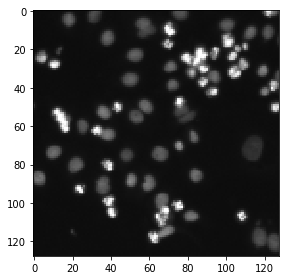

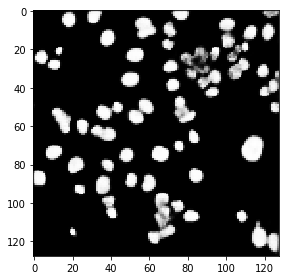

In [159]:
import matplotlib.pyplot as plt
import StringIO
import json
import numpy

# Indicamos el tamaño de las imágenes
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

# Normalizamos la imágen de entrada para que tenga el mismo tamaño que la de salida
test_img = imread(StringIO.StringIO(f_image))[:,:,:IMG_CHANNELS]
test_img = resize(test_img, (IMG_HEIGHT, IMG_WIDTH), mode='constant')

# Cargamos los datos resultantes de la predicción (JSON) en un array Numpy
pred_img = json.loads(pred)
pred_array = numpy.array(pred_img)

# Muestra la imagen de entrada enviada al modelo
imshow(test_img)
plt.show()

# Muestra la predicción del modelo
imshow(np.squeeze(pred_array))
plt.show()

# Eliminar el endpoint
Es posible eliminar el endpoint de SageMaker de forma programática. Simplemente se ejecuta la siguiente línea de código para eliminar el endpoint y la infraestructura que está ejecutando los contenedores Docker con el servidor web.

In [55]:
#sagemaker_session.delete_endpoint(predictor.endpoint)

INFO:sagemaker:Deleting endpoint with name: unet-2018-06-30-20-57-14-254
